<a href="https://colab.research.google.com/github/Alex112525/Doom-with-AI/blob/master/DeepQDoom_Defend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get update
!sudo apt-get install libsdl2-dev --fix-missing
!apt-get install build-essential zlib1g-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

In [ ]:
!pip install vizdoom

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd '/gdrive/My Drive/vizDoom'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/vizDoom


In [ ]:
#!git clone https://github.com/mwydmuch/ViZDoom.git

In [ ]:
%cd '/gdrive/My Drive/vizDoom/ViZDoom/scenarios'
!ls

/gdrive/My Drive/vizDoom/ViZDoom/scenarios
basic.cfg		    defend_the_line.wad		  Plot_300.png
basic.wad		    health_gathering.cfg	  Plot_99.png
bots.cfg		    health_gathering_supreme.cfg  predict_position.cfg
cig.cfg			    health_gathering_supreme.wad  predict_position.wad
cig.wad			    health_gathering.wad	  README.md
cig_with_unknown.wad	    learning.cfg		  rocket_basic.cfg
CorredorDeepQ.cfg	    multi.cfg			  rocket_basic.wad
deadly_corridor.cfg	    multi_deathmatch.wad	  shoot.jpg
deadly_corridor.wad	    multi_duel.cfg		  simpler_basic.cfg
deathmatch.cfg		    multi_duel.wad		  simpler_basic.wad
deathmatch.wad		    my_way_home.cfg		  take_cover.cfg
DeepQDoom.cfg		    my_way_home.wad		  take_cover.wad
defend_the_center.cfg	    oblige.cfg			  _vizdoom
defend_the_center.cfg.gdoc  Plot_100.png		  _vizdoom.ini
defend_the_center.wad	    Plot_199.png
defend_the_line.cfg	    Plot_200.png


In [ ]:
DEFAULT_CONFIG = '/gdrive/My Drive/vizDoom/ViZDoom/scenarios/defend_the_center.cfg'
PATH = '/gdrive/My Drive/vizDoom/ViZDoom/DeepQDoom.pth'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import models
import torchvision.transforms as T 

from PIL import Image

In [ ]:
from vizdoom import *
import random
import math
import cv2
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import count
from collections import namedtuple

plt.ion()
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [ ]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(3, 8, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(8, 20, kernel_size=(5, 5))

        self.fc1 = nn.Linear(7480, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        x = F.log_softmax(x, dim=1)

        return x

    def num_flat_features(self, x):
        size = x.size()[1:] 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

Experiencia 

In [ ]:
Experience = namedtuple('Experience',('state', 'action', 'next_state', 'reward'))
e = Experience(10,12,3,4)
e

Experience(state=10, action=12, next_state=3, reward=4)

Memoria de repeticion

In [ ]:
class ReplayMemory():
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.push_count = 0

  def push(self, experience):
    if len(self.memory) < self.capacity:
      self.memory.append(experience)
    else:
      self.memory[self.push_count % self.capacity] = experience
      self.push_count += 1

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)
  
  def can_provide_sample(self, batch_size):
    return len(self.memory) >= batch_size

  def len_memory(self):
    return len(self.memory)

Epsilon Greedy Strategy

In [ ]:
class EpsilonGreedyStrategy():
  def __init__(self, start, end, decay):
    self.start = start
    self.end = end
    self.decay = decay
  
  def get_exploration_rate(self, current_step):
    return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [ ]:
E = EpsilonGreedyStrategy(1, 0.01, 0.005)
print(E.get_exploration_rate(1225))

0.012165616207001056


Reinforcement Learning Agent

In [ ]:
class Agent():
  def __init__(self, strategy, num_actions):
    self.current_step = 0
    self.strategy = strategy
    self.num_actions = num_actions
    self.random_actions = 0

  def select_action(self, state, policy_net):
    rate = self.strategy.get_exploration_rate(self.current_step)
    self.current_step += 1
    if rate > random.random():
      self.random_actions += 1
      action = random.randrange(self.num_actions) # explore 
      return torch.tensor([action])
    else:
      with torch.no_grad():
        return policy_net(state).argmax(dim=1) # exploit 
  
  def reset_count(self, step):
    self.random_actions = 0
    self.current_step = step

Enviroment Manager

In [ ]:
class DoomEnvManager():
  def __init__(self):
    self.game = DoomGame()
    self.game.load_config(DEFAULT_CONFIG)
    self.game.set_screen_format(ScreenFormat.RGB24)
    self.game.set_screen_resolution(ScreenResolution.RES_320X240)
    self.game.set_window_visible(False)
    self.current_screen = None
    self.global_reward = 0
    self.done = False
    self.pos = 0
    self.raw_img = None
    self.frame_reward = False 
  
  def init(self):
    self.global_reward = 0
    self.game.init()
    self.game.new_episode()

  def close(self):
    self.game.close()

  def reset(self):
    self.close()
    self.init()
  
  def num_actions_available(self):
    return self.game.get_available_buttons_size()

  def take_action(self, action, mode="train"):      
    reward = self.game.make_action(self.transform_action(action))
    reward = 0
    current_pos = self.get_reward(action)
    # print(f"current pos: {current_pos}. Last pos: {self.pos}")
    if mode == "train":
      if self.pos != 0 or current_pos > 0:
        if action == 0 or action == 1:
          x = abs(current_pos - 30)
          y = abs(self.pos - 30)
          if x < y: 
            reward += 1
      if current_pos == -1 and action == 0:
        reward += 1
    if current_pos == -2 and action == 2:
      reward += 1

    self.pos = current_pos 
    self.global_reward += reward
    if reward != 0:
      self.frame_reward = True
    else:
      self.frame_reward = False
    self.done = self.game.is_player_dead()
    return torch.tensor([reward])
  
  def just_starting(self):
    return self.current_screen is None

  def get_state(self, opc=0):
    if self.just_starting():
      self.current_screen = self.get_processed_screen()
      black_screen = torch.zeros_like(self.current_screen)
      return black_screen
    elif self.game.is_player_dead():
      black_screen = torch.zeros_like(self.current_screen)
      return black_screen
    else:
      s1 = self.current_screen
      s2 = self.get_processed_screen()
      if opc == 0:
        self.current_screen = s2
      return s2 - s1

  def get_processed_screen(self):
    state = self.game.get_state()
    img = state.screen_buffer
    self.raw_img = img
    obs_h, obs_w, _ = img.shape
    img = img[0:int(obs_h*0.89), :, :]
    img = img.transpose((2, 0, 1))
    screen = np.ascontiguousarray(img, dtype=np.float32) / 255
    obs = torch.from_numpy(screen)

    resize = T.Compose([
        T.ToPILImage()
        ,T.Resize((80,100))
        ,T.ToTensor()
        ,T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    return resize(obs).unsqueeze(0)
  
  def transform_action(self, action):
    shoot = [0, 0, 1]
    left = [1, 0, 0]
    right = [0, 1, 0]
    if action == 0:
      return left
    elif action == 1:
      return right
    elif action == 2:
      return shoot
  
  def get_reward(self, action):
    img = self.get_state(1)
    img = img.squeeze(0).permute(1, 2, 0)
    img = img.numpy()
    img = img * 255
    img = np.ascontiguousarray(img, dtype=np.int16)
    enemi = img[35:45, 20:80, :]
    
    R = np.array(enemi[:, :, 0])
    G = np.array(enemi[:, :, 1])
    B = np.array(enemi[:, :, 2])  

    S = R + G + B
    # print(S.shape)
    line_medium = np.array([x for x in S[5]])
    line_high = np.array([x for x in S[-2]])
    line_low = np.array([x for x in S[1]])

    line = line_medium + line_high + line_low
    line = line // 3 
    max_pixel = max(line)

    # print("M", line_medium)
    # print("H", line_high)
    # print("L", line_low)
    # print("T",line)
    # print(max_pixel)
    # print(np.where(line == np.amax(line)))

    plt.figure()
    plt.imshow(enemi)
    plt.title('Objetive')
    plt.show()
    
    if max_pixel < 50:
      # print("No wacho nada")
      return -1
    if line[28] > 50 or line[29] > 50 or line[31] > 50 or line [30] > 50:
      # print("¡¡Muere Perro!!")
      return -2
    # print("Gira chaval")   

    return np.where(line == np.amax(line))[0][0]

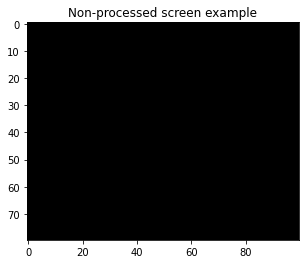

In [ ]:
Doom = DoomEnvManager()
Doom.init()
screen = Doom.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu())
plt.title('Non-processed screen example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


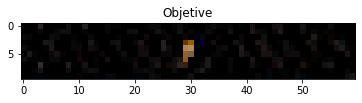

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


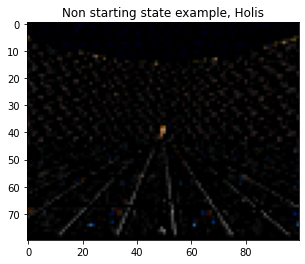

Global reward: 0


In [ ]:
for i in range(1):
    Doom.take_action(0)

screen = Doom.get_state()
plt.figure()

plt.imshow(screen.squeeze(0).permute(1, 2, 0))
plt.title('Non starting state example, Holis')
plt.show()
print("Global reward:", Doom.global_reward)

In [ ]:
def load_network():
    load_net = DQN()
    load_net.load_state_dict(torch.load(PATH))
    return load_net

Visualizacion

In [ ]:
def plot(values, rewards, random, moving_avg_period, episode):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values, label='Livetime', marker='^')
    plt.plot(rewards, label='Reward', linestyle = 'dashed')
    plt.plot(random, label='Random moves', linestyle='dotted')
    plt.legend(loc = 'lower left')

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)  
    if len(values)%100 == 0:
      plt.savefig(f"Plot_{episode}.png", bbox_inches='tight', dpi=300,)
      print("saved")  
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [ ]:
plot(np.random.rand(300), np.random.rand(200), np.random.rand(100), 100, 100)

Procesamiento de experiencias

In [ ]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [ ]:
class QValues():
  @staticmethod
  def get_current(policy_net, states, actions):
    return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

  @staticmethod        
  def get_next(target_net, next_states):                
    final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
    non_final_state_locations = (final_state_locations == False)
    non_final_states = next_states[non_final_state_locations]
    batch_size = next_states.shape[0]
    values = torch.zeros(batch_size)
    values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
    return values

Entrenamiento

In [ ]:
batch_size = 250
gamma = 0.999
eps_start = 0.5
eps_end = 0.005
eps_decay = 0.0005
target_update = 10
memory_size = 50000
lr = 0.001
# num_episodes = 1000

Doom = DoomEnvManager()
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, Doom.num_actions_available())
memory = ReplayMemory(memory_size)

policy_net = DQN()
target_net = DQN()

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [ ]:
def Train(num_episodes):
  episode_durations = []
  Total_rewards = []
  random_moves = []

  for episode in range(num_episodes):
    t_train = 0
    Doom.reset()
    state = Doom.get_state()
    # print(episode)

    for timestep in count():
      action = agent.select_action(state, policy_net)
      reward = Doom.take_action(action)

      if Doom.done:
        if episode%200 == 0:
          episode_durations = []
          Total_rewards = []
          random_moves = []
        episode_durations.append(timestep)
        Total_rewards.append(Doom.global_reward)
        random_moves.append(agent.random_actions)
        # print(random_moves)
        agent.reset_count(episode*50)
        plot(episode_durations, Total_rewards, random_moves, 20, episode)
        break

      next_state = Doom.get_state()

      if Doom.frame_reward:
        memory.push(Experience(state, action, next_state, reward))
      state = next_state
      
      if memory.can_provide_sample(batch_size) and t_train == 25:
        experiences = memory.sample(batch_size)
        states, actions, rewards, next_states = extract_tensors(experiences)

        current_q_values = QValues.get_current(policy_net, states, actions)
        next_q_values = QValues.get_next(target_net, next_states)
        target_q_values = (next_q_values * gamma) + rewards

        loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        t_train = 0

      t_train += 1
      
    if episode % target_update == 0:
      target_net.load_state_dict(policy_net.state_dict())

  Doom.close()
  torch.save(target_net.state_dict(), PATH)

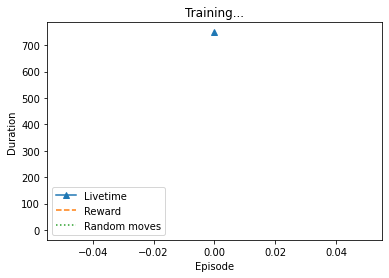

Episode 1 
 20 episode moving avg: 0.0


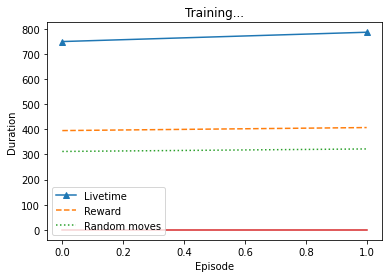

Episode 2 
 20 episode moving avg: 0.0


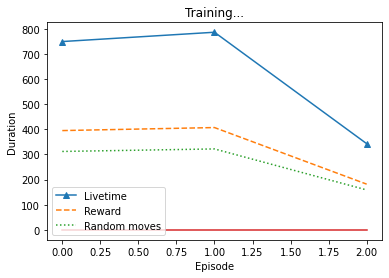

Episode 3 
 20 episode moving avg: 0.0


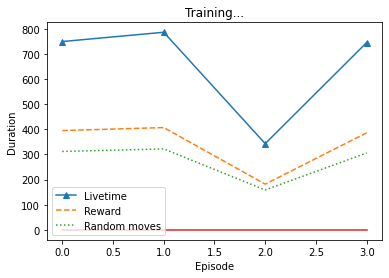

Episode 4 
 20 episode moving avg: 0.0


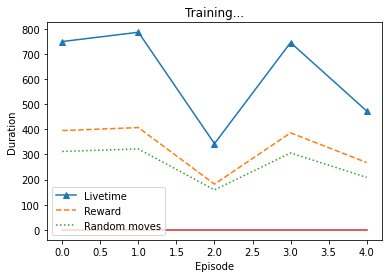

Episode 5 
 20 episode moving avg: 0.0


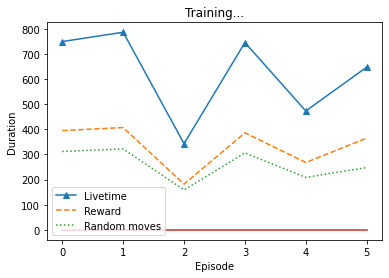

Episode 6 
 20 episode moving avg: 0.0


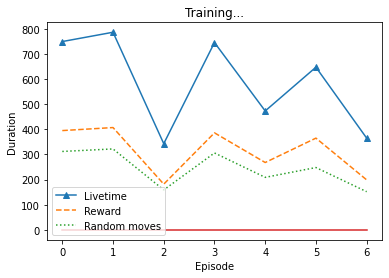

Episode 7 
 20 episode moving avg: 0.0


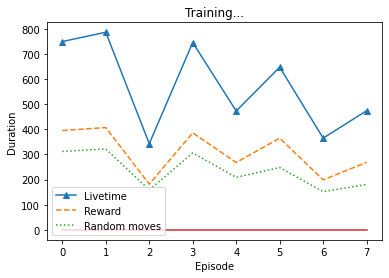

Episode 8 
 20 episode moving avg: 0.0


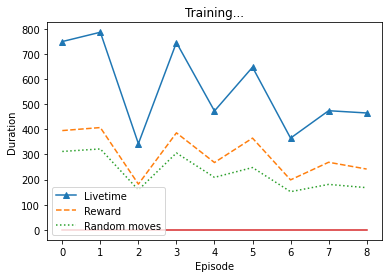

Episode 9 
 20 episode moving avg: 0.0


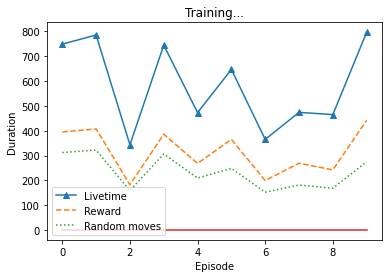

Episode 10 
 20 episode moving avg: 0.0


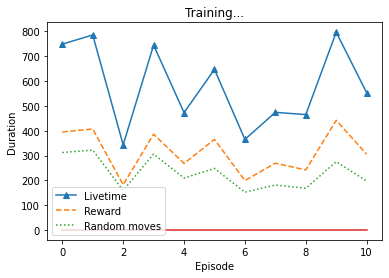

Episode 11 
 20 episode moving avg: 0.0


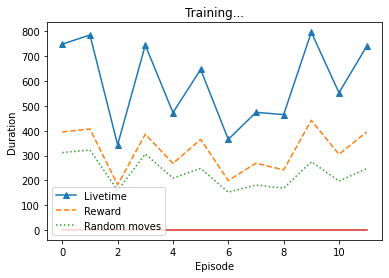

Episode 12 
 20 episode moving avg: 0.0


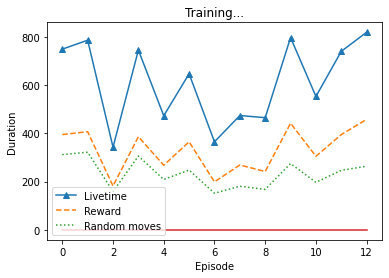

Episode 13 
 20 episode moving avg: 0.0


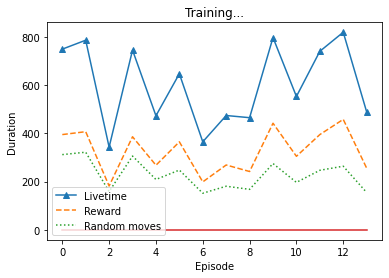

Episode 14 
 20 episode moving avg: 0.0


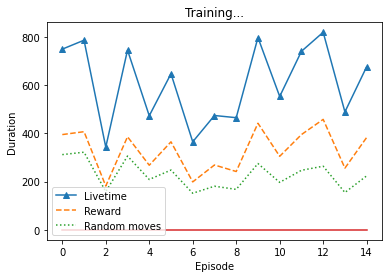

Episode 15 
 20 episode moving avg: 0.0


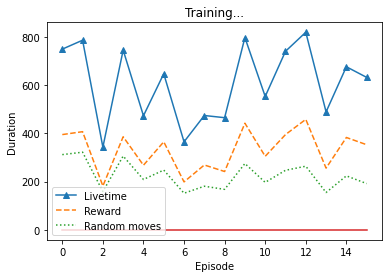

Episode 16 
 20 episode moving avg: 0.0


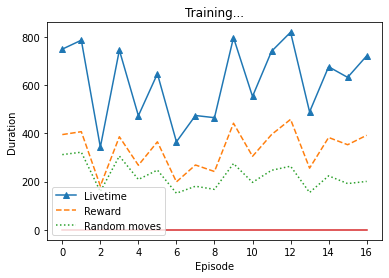

Episode 17 
 20 episode moving avg: 0.0


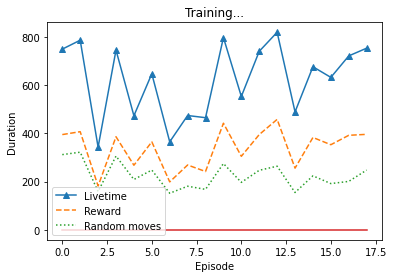

Episode 18 
 20 episode moving avg: 0.0


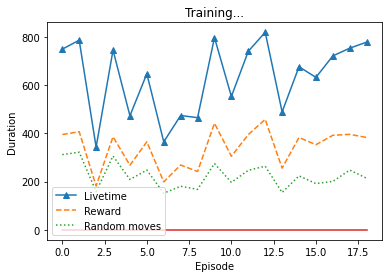

Episode 19 
 20 episode moving avg: 0.0


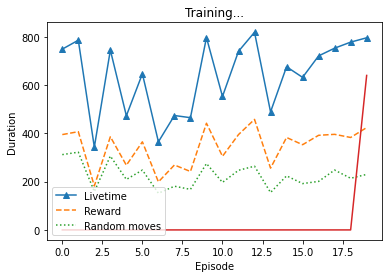

Episode 20 
 20 episode moving avg: 640.05


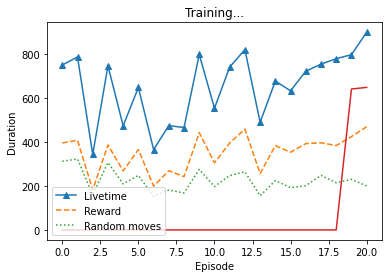

Episode 21 
 20 episode moving avg: 647.5


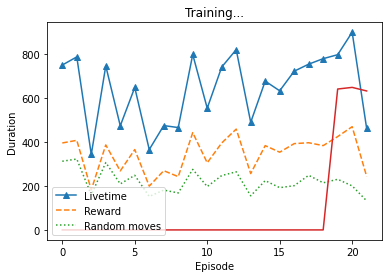

Episode 22 
 20 episode moving avg: 631.25


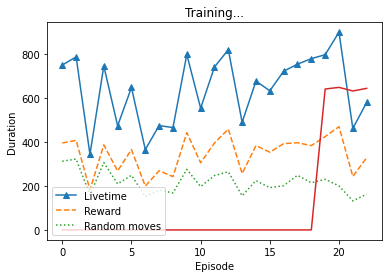

Episode 23 
 20 episode moving avg: 643.05


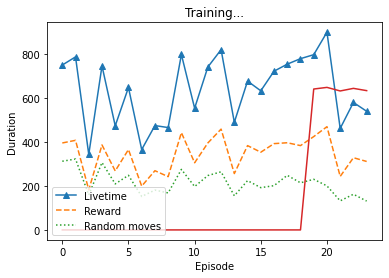

Episode 24 
 20 episode moving avg: 632.75


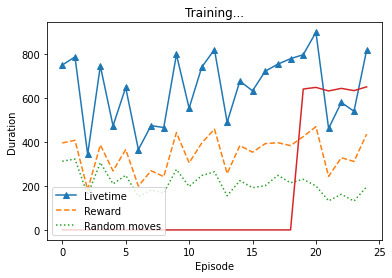

Episode 25 
 20 episode moving avg: 649.95


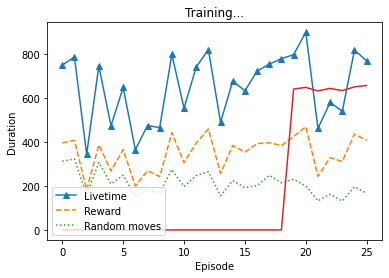

Episode 26 
 20 episode moving avg: 656.0


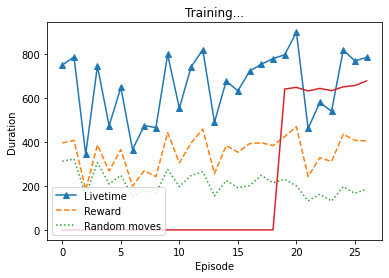

Episode 27 
 20 episode moving avg: 676.95


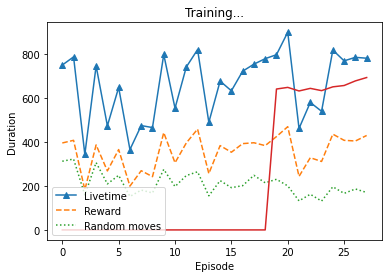

Episode 28 
 20 episode moving avg: 692.25


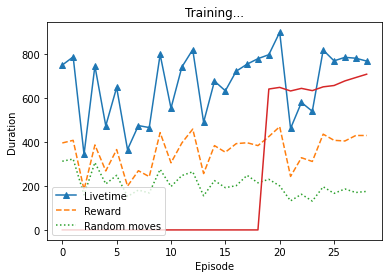

Episode 29 
 20 episode moving avg: 707.35


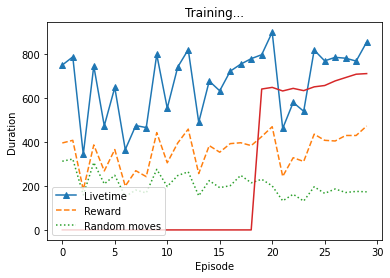

Episode 30 
 20 episode moving avg: 710.15


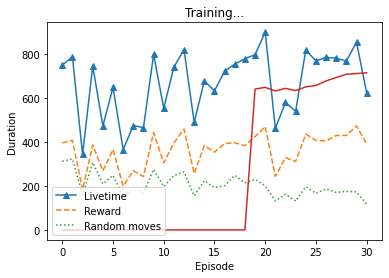

Episode 31 
 20 episode moving avg: 713.65


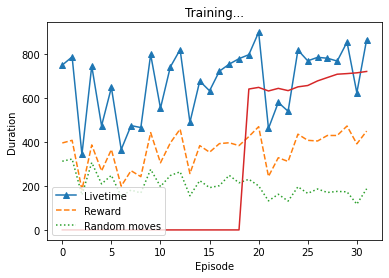

Episode 32 
 20 episode moving avg: 719.9


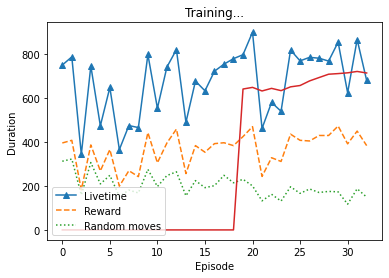

Episode 33 
 20 episode moving avg: 712.9


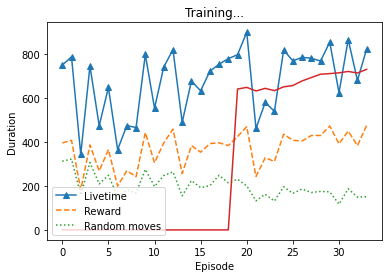

Episode 34 
 20 episode moving avg: 729.55


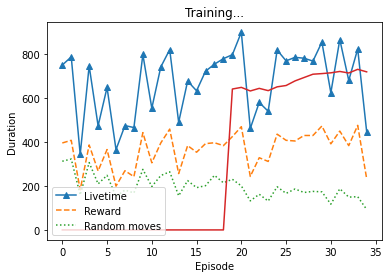

Episode 35 
 20 episode moving avg: 718.1


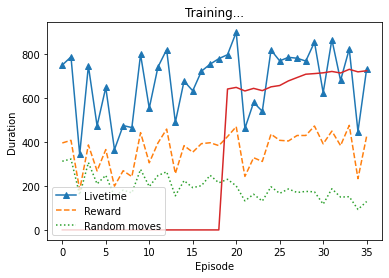

Episode 36 
 20 episode moving avg: 723.1


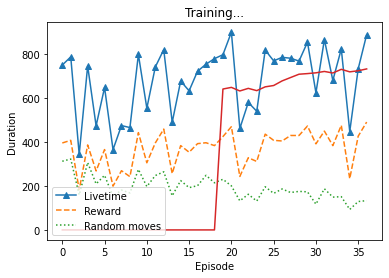

Episode 37 
 20 episode moving avg: 731.4


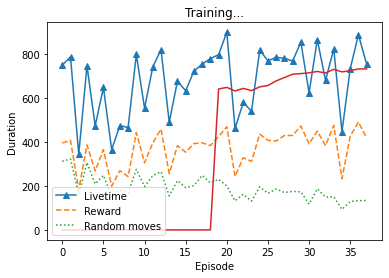

Episode 38 
 20 episode moving avg: 731.35


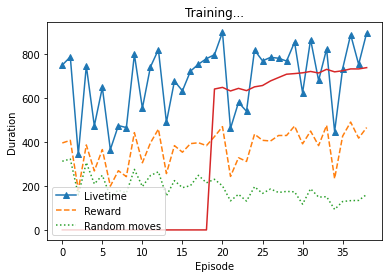

Episode 39 
 20 episode moving avg: 737.2


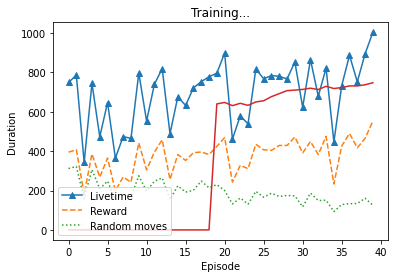

Episode 40 
 20 episode moving avg: 747.6


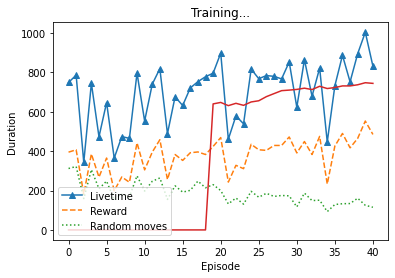

Episode 41 
 20 episode moving avg: 744.3


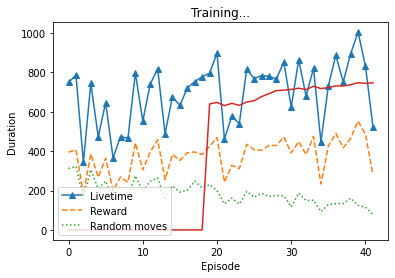

Episode 42 
 20 episode moving avg: 747.5


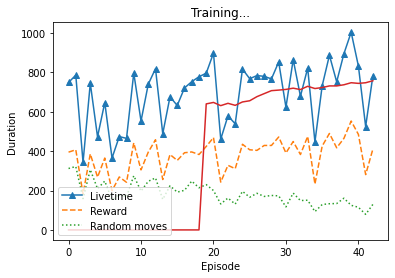

Episode 43 
 20 episode moving avg: 757.75


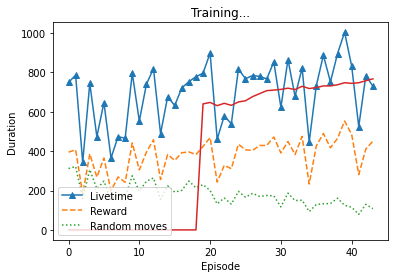

Episode 44 
 20 episode moving avg: 767.3


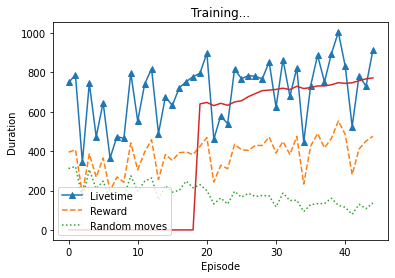

Episode 45 
 20 episode moving avg: 772.1


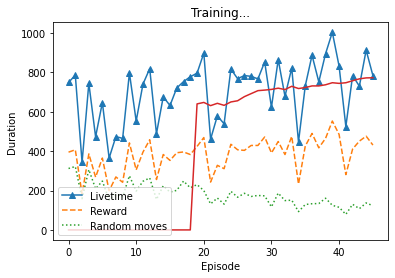

Episode 46 
 20 episode moving avg: 772.9


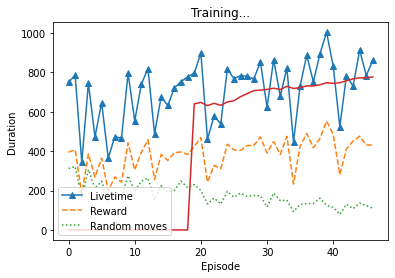

Episode 47 
 20 episode moving avg: 776.85


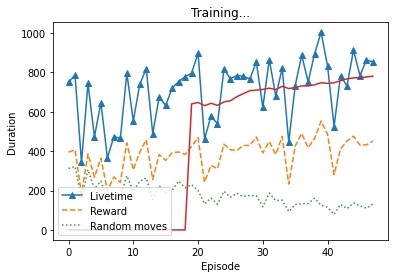

Episode 48 
 20 episode moving avg: 780.55


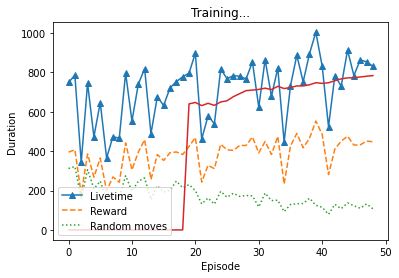

Episode 49 
 20 episode moving avg: 783.75


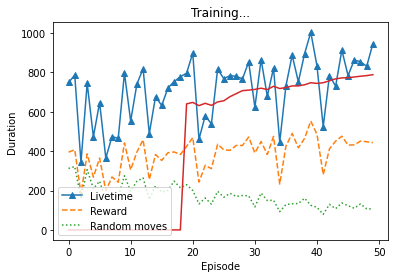

Episode 50 
 20 episode moving avg: 788.4


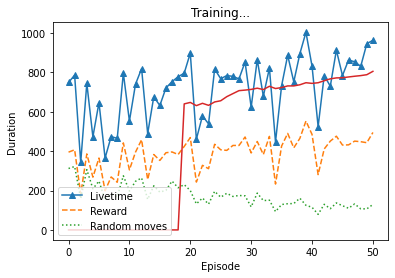

Episode 51 
 20 episode moving avg: 805.4


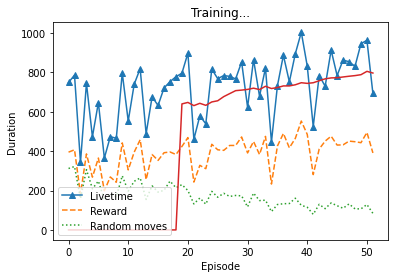

Episode 52 
 20 episode moving avg: 796.8


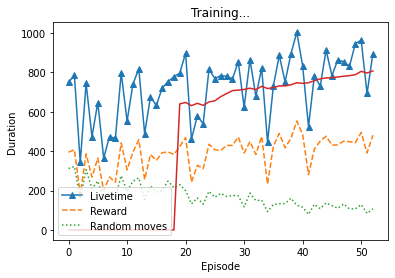

Episode 53 
 20 episode moving avg: 807.65


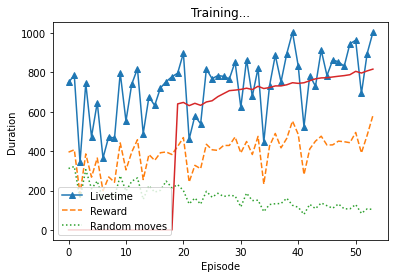

Episode 54 
 20 episode moving avg: 816.7


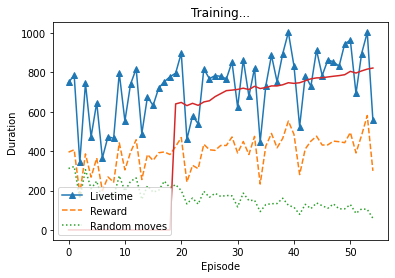

Episode 55 
 20 episode moving avg: 822.2


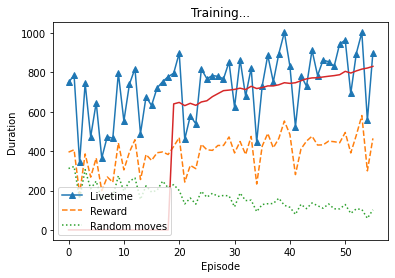

Episode 56 
 20 episode moving avg: 830.65


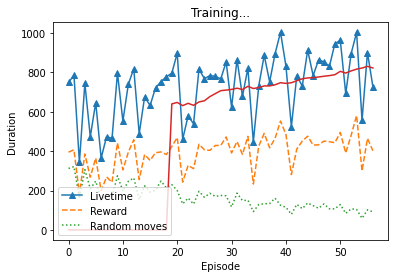

Episode 57 
 20 episode moving avg: 822.65


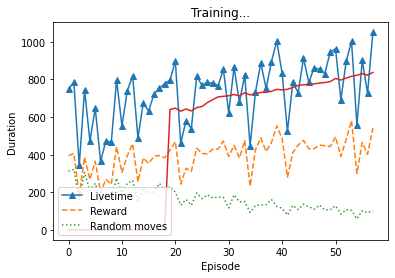

Episode 58 
 20 episode moving avg: 837.6


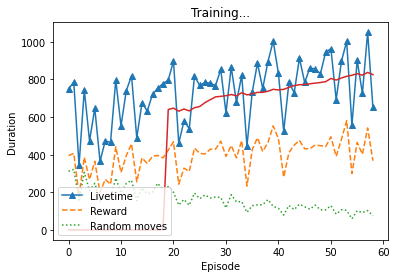

Episode 59 
 20 episode moving avg: 825.4


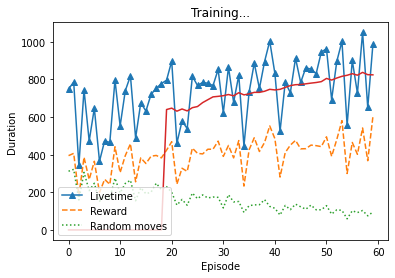

Episode 60 
 20 episode moving avg: 824.55


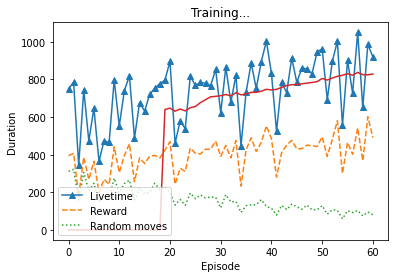

Episode 61 
 20 episode moving avg: 828.9


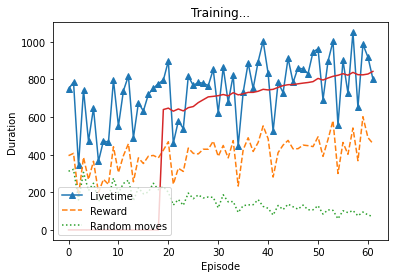

Episode 62 
 20 episode moving avg: 842.8


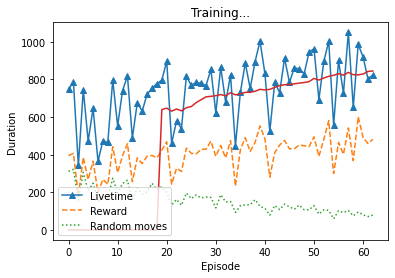

Episode 63 
 20 episode moving avg: 844.8


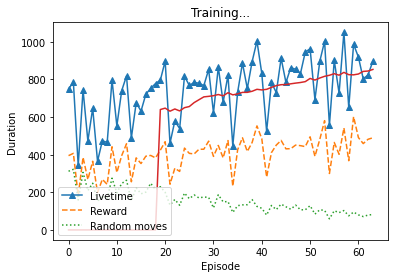

Episode 64 
 20 episode moving avg: 853.2


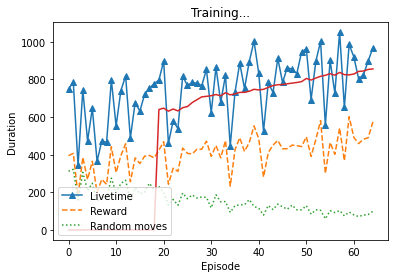

Episode 65 
 20 episode moving avg: 855.95


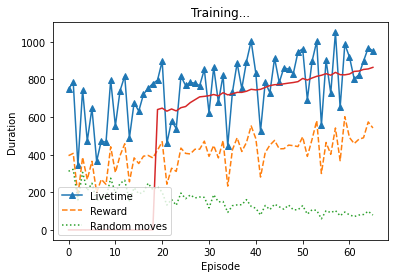

Episode 66 
 20 episode moving avg: 864.35


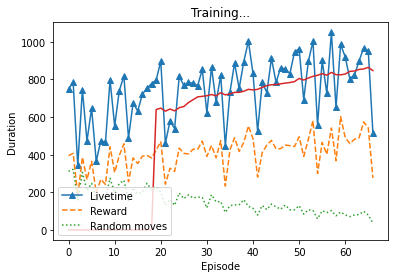

Episode 67 
 20 episode moving avg: 847.0


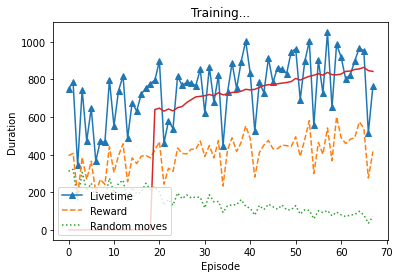

Episode 68 
 20 episode moving avg: 842.55


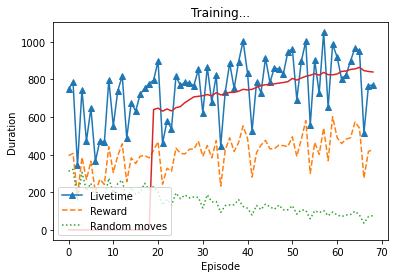

Episode 69 
 20 episode moving avg: 839.55


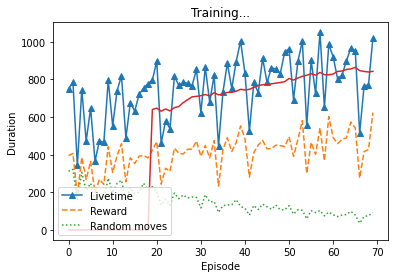

Episode 70 
 20 episode moving avg: 843.25


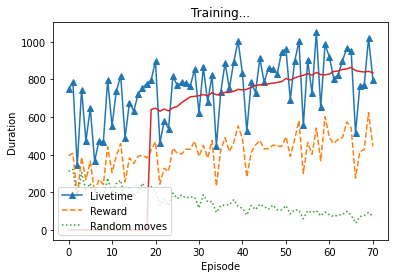

Episode 71 
 20 episode moving avg: 835.05


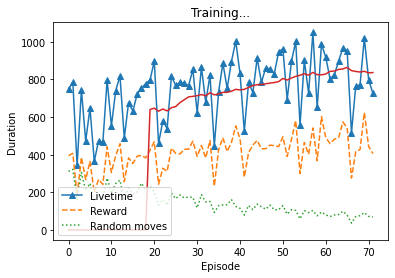

Episode 72 
 20 episode moving avg: 836.7


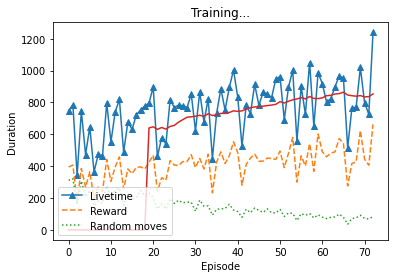

Episode 73 
 20 episode moving avg: 853.95


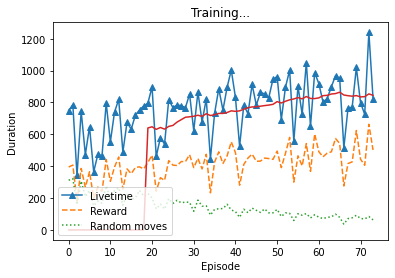

Episode 74 
 20 episode moving avg: 845.05


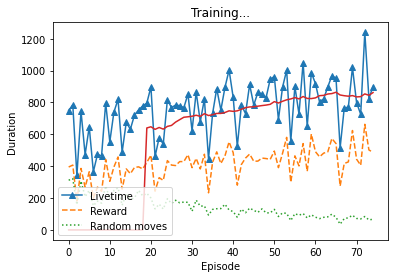

Episode 75 
 20 episode moving avg: 862.2


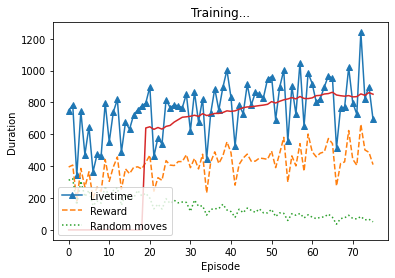

Episode 76 
 20 episode moving avg: 851.85


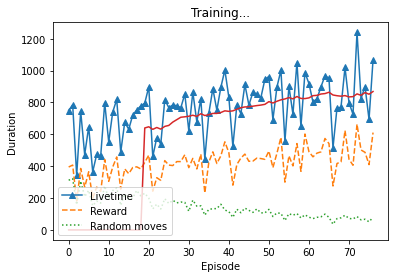

Episode 77 
 20 episode moving avg: 868.85


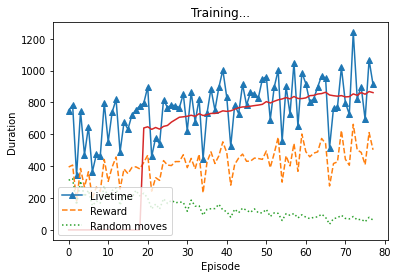

Episode 78 
 20 episode moving avg: 861.95


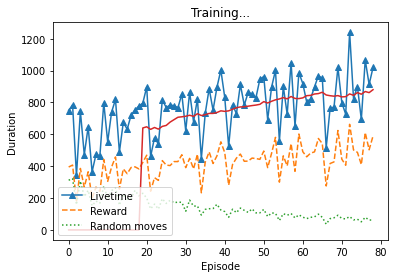

Episode 79 
 20 episode moving avg: 880.4


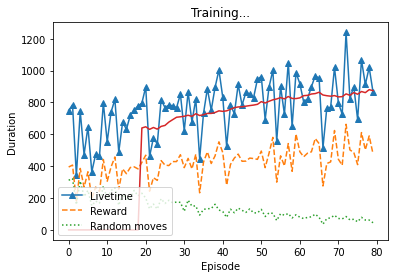

Episode 80 
 20 episode moving avg: 874.3


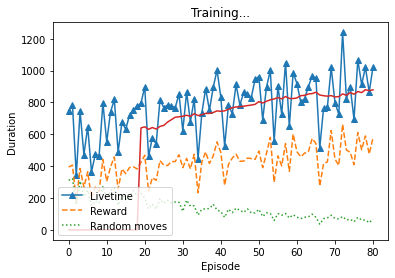

Episode 81 
 20 episode moving avg: 879.6


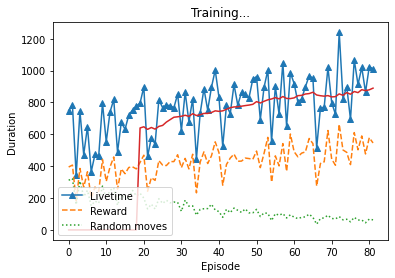

Episode 82 
 20 episode moving avg: 890.05


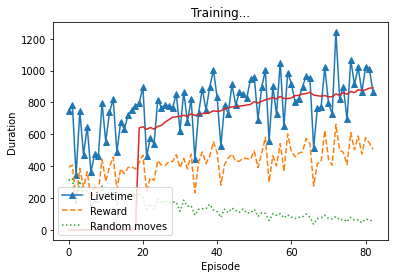

Episode 83 
 20 episode moving avg: 892.05


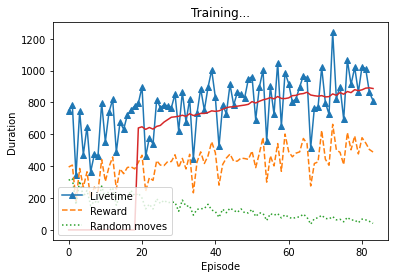

Episode 84 
 20 episode moving avg: 887.75


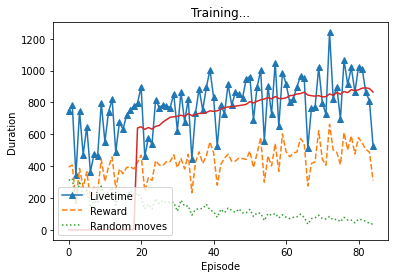

Episode 85 
 20 episode moving avg: 865.75


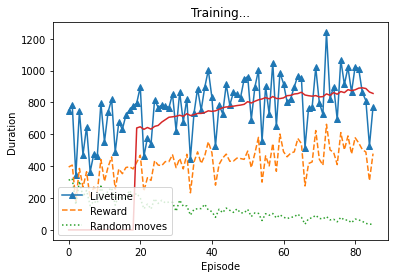

Episode 86 
 20 episode moving avg: 856.8


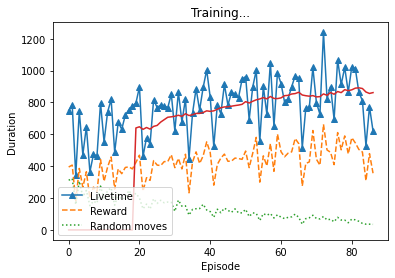

Episode 87 
 20 episode moving avg: 862.05


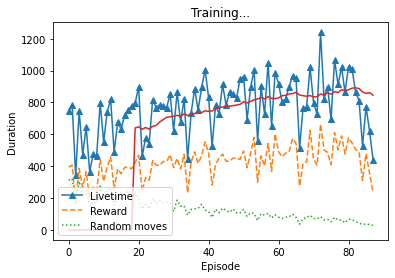

Episode 88 
 20 episode moving avg: 845.85


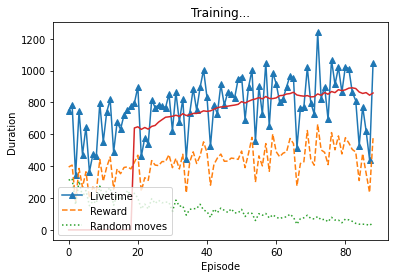

Episode 89 
 20 episode moving avg: 859.6


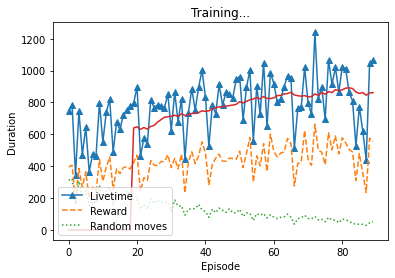

Episode 90 
 20 episode moving avg: 861.9


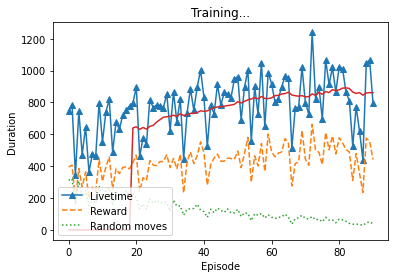

Episode 91 
 20 episode moving avg: 861.75


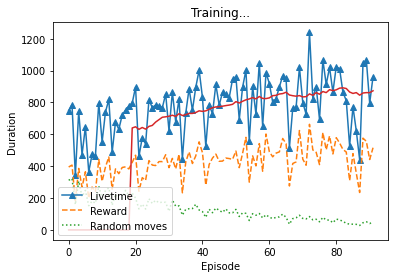

Episode 92 
 20 episode moving avg: 873.55


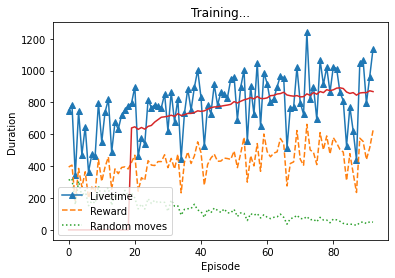

Episode 93 
 20 episode moving avg: 868.35


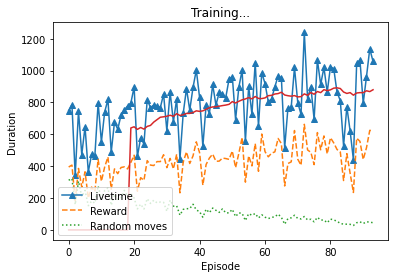

Episode 94 
 20 episode moving avg: 880.0


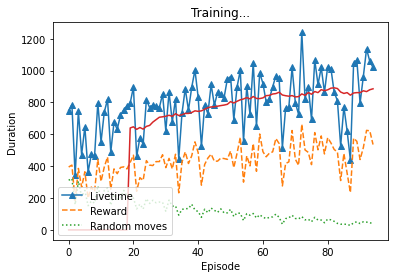

Episode 95 
 20 episode moving avg: 886.0


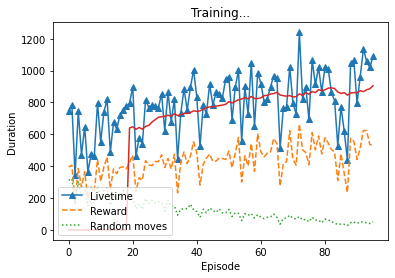

Episode 96 
 20 episode moving avg: 905.75


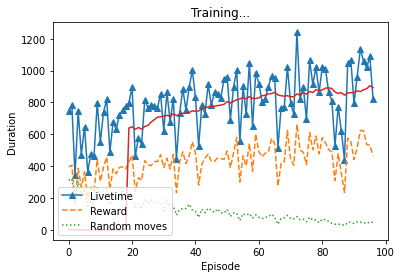

Episode 97 
 20 episode moving avg: 893.6


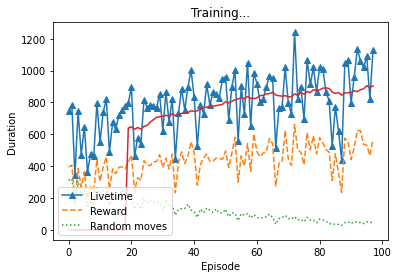

Episode 98 
 20 episode moving avg: 904.5


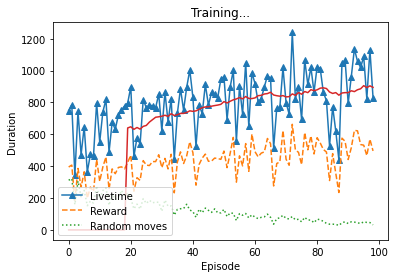

Episode 99 
 20 episode moving avg: 895.05
saved


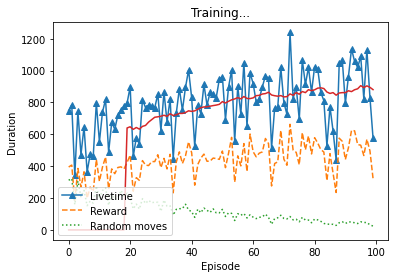

Episode 100 
 20 episode moving avg: 880.7


In [ ]:
Train(100)

Validación

In [ ]:
def print_screen(img):
  plt.figure()
  obs_h, obs_w, _ = img.shape
  screen = np.ascontiguousarray(img, dtype=np.float32) / 255
  obs = torch.from_numpy(screen)

  plt.imshow(obs.numpy(), interpolation='none')
  plt.show()

In [ ]:
def eval(num_episodes=1):
  net = load_network()
  net.eval()
  Doom = DoomEnvManager()

  for episode in range(num_episodes):
    t_render = 0
    t_eval = 0
    Doom.reset()
    state = Doom.get_state()

    for timestep in count():
      output = net(state)
      _, predict = torch.max(output.data, 1)
      action = predict.item()
      print("Action: ",  action)
      reward = Doom.take_action(action, "eval")

      next_state = Doom.get_state()
      state = next_state
      if t_render == 3:
          print_screen(Doom.raw_img)
          t_render = 0

      t_eval += 1
      t_render += 1
      if Doom.done:
        break
  print("Time steps: ", t_eval)
  print("Global reward:", Doom.global_reward)
  Doom.close()

In [ ]:
eval()